In [1]:
import wandb

wandb.init()

wandb: Currently logged in as: xhradskyp. Use `wandb login --relogin` to force relogin


In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches as patches

In [2]:
images = np.load("data/images.npy")
labels = np.load("data/labels.npy")


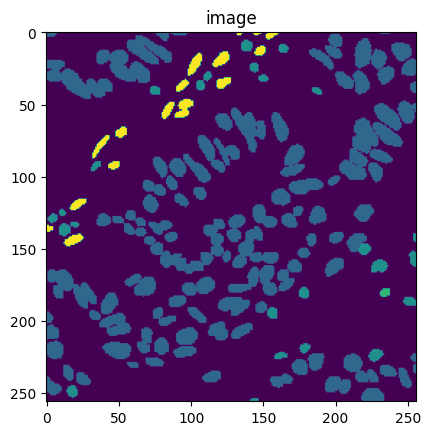

array([0, 2, 3, 4, 6], dtype=uint16)

In [3]:
plt.imshow(labels[4320][..., 1])
plt.title("image")
plt.show()
np.unique(labels[4320][..., 1])

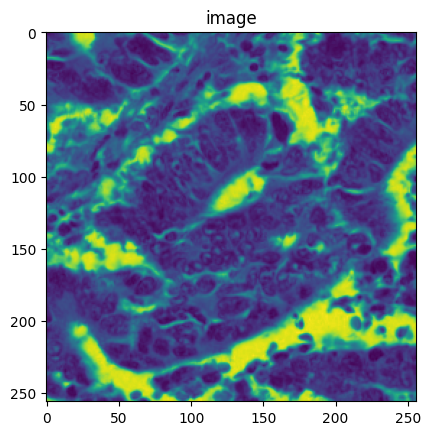

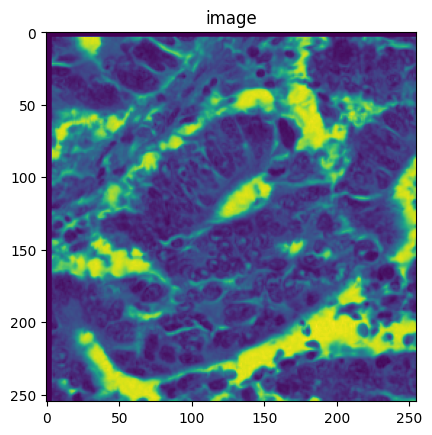

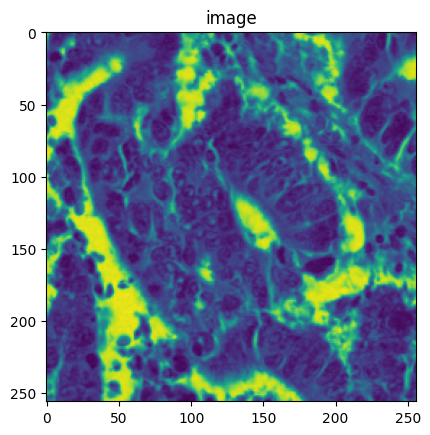

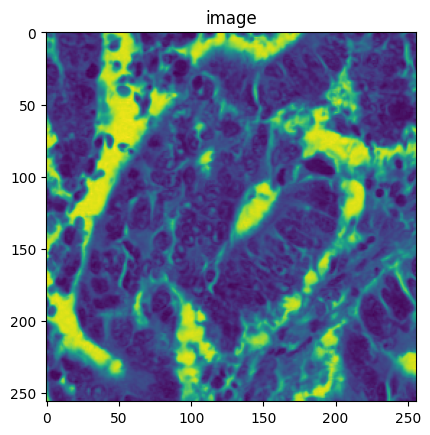

In [4]:
img = images[4320][..., 1]

plt.imshow(img)
plt.title("image")
plt.show()

translation_matrix = np.float32([ [1,0,4], [0,1,4] ])
img_translation = cv2.warpAffine(img, translation_matrix, (255, 255))

plt.imshow(img_translation)
plt.title("image")
plt.show()

img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(img)
plt.title("image")
plt.show()

img = cv2.flip(img, 0)

plt.imshow(img)
plt.title("image")
plt.show()

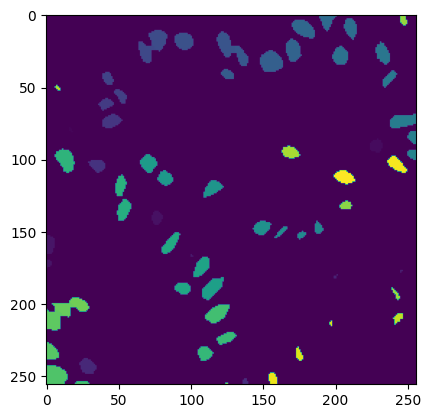

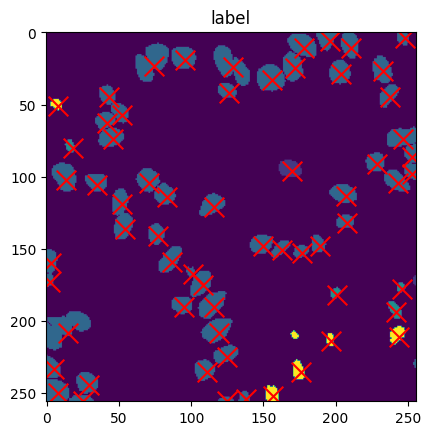

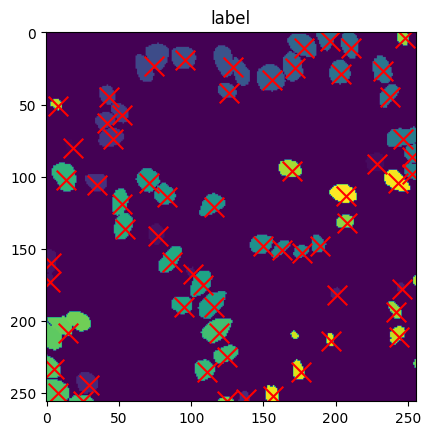

[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]


In [5]:
i = 321
individuals = np.uint8(labels[i][...,0])
label = np.uint8(labels[i][...,1])
image = images[i]
size = 32

img = individuals.copy()

image_size = individuals.shape[0]

kernel = np.ones((4, 4), np.uint8)
img_erosion = cv2.erode(img, kernel, iterations=1)

plt.imshow(img_erosion)
plt.show()

# plt.imshow(img)
# plt.show()

contours, hierarchy= cv2.findContours(img_erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)

# plt.imshow(label)
# plt.imshow(edges, cmap='jet', alpha=0.5)
# plt.title("label")
# plt.show()

# print(sorted_contours[0][0][0][1])
# fig, ax = plt.subplots()
# plt.imshow(label)
# for c in sorted_contours:
#     x,y,w,h= cv2.boundingRect(c)
#     # print(x, y, w, h)
#     # Create a Rectangle patch
#     rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

#     # Add the patch to the Axes
#     ax.add_patch(rect)
    
# plt.title("label")
# plt.show()

points = []
classes = []

for i, c in enumerate(sorted_contours):
    x,y,w,h= cv2.boundingRect(c)
    slice_h_1 = y-(size-h)//2
    slice_h_2 = y-(size-h)//2 + size
    slice_w_1 = x-(size-w)//2
    slice_w_2 = x-(size-w)//2 + size
    
    # print(slice_w_1, slice_w_2, slice_h_1, slice_h_2)
    middle_x = slice_w_1+(slice_w_2-slice_w_1)//2
    middle_y = slice_h_1+(slice_h_2-slice_h_1)//2
    # print(middle_x, middle_y)
    if middle_x > 255:
        middle_x = 255
    if middle_x < 0:
        middle_x = 0
    if middle_y > 255:
        middle_y = 255
    if middle_y < 0:
        middle_y = 0
    
    if(slice_h_1 < 0): 
        slice_h_1, slice_h_2 = (0, size)
    if(slice_w_1 < 0): 
        slice_w_1, slice_w_2 = (0, size)
    if(slice_h_2 > image_size): 
        slice_h_1, slice_h_2 = (image_size-size, image_size)
    if(slice_w_2 > image_size): 
        slice_w_1, slice_w_2 = (image_size-size, image_size)
    
    img = label[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
    current_class = label[middle_x, middle_y]
    classes.append(current_class)
    
    points.append(np.array([middle_x, middle_y]))
    
    # plt.imshow(img)
    # plt.title("image")
    # plt.show()
    # print(current_class)
points = np.array(points)
plt.imshow(label)
plt.scatter(points[:, 0], points[:, 1], marker="x", color="red", s=200)
# plt.imshow(edges, cmap='jet', alpha=0.5)
plt.title("label")
plt.show()

plt.imshow(individuals)
plt.scatter(points[:, 0], points[:, 1], marker="x", color="red", s=200)
plt.title("label")
plt.show()

print(classes)
    

In [7]:
np.unique(individuals)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69], dtype=uint8)

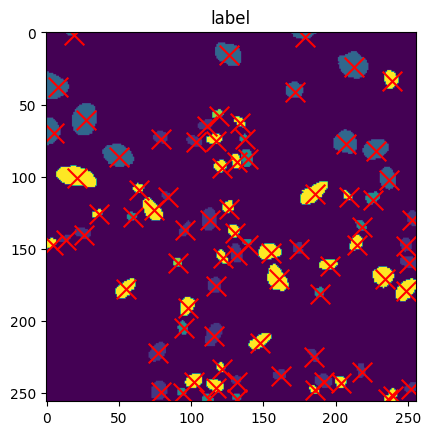

[2, 5, 2, 3, 2, 1, 3, 3, 3, 3, 5, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6]


In [18]:
i = 345
individuals = np.uint8(labels[i][...,0])
label = np.uint8(labels[i][...,1])
image = images[i]
size = 32

img = individuals.copy()

image_size = individuals.shape[0]

points = []
classes = []

for ind in np.unique(individuals):
    if ind == 0:
        continue
    my_img = individuals.copy()
    my_img[my_img != ind] = 0
    contours, hierarchy= cv2.findContours(my_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)

    for i, c in enumerate(sorted_contours):
        x,y,w,h= cv2.boundingRect(c)
        slice_h_1 = y-(size-h)//2
        slice_h_2 = y-(size-h)//2 + size
        slice_w_1 = x-(size-w)//2
        slice_w_2 = x-(size-w)//2 + size
        
        cell = label[y:y+h, x:x+w]
        current_class = np.max(cell)
        

        # print(slice_w_1, slice_w_2, slice_h_1, slice_h_2)
        middle_x = slice_w_1+(slice_w_2-slice_w_1)//2
        middle_y = slice_h_1+(slice_h_2-slice_h_1)//2
        # print(middle_x, middle_y)
        if middle_x > 255:
            middle_x = 255
        if middle_x < 0:
            middle_x = 0
        if middle_y > 255:
            middle_y = 255
        if middle_y < 0:
            middle_y = 0

        if(slice_h_1 < 0): 
            slice_h_1, slice_h_2 = (0, size)
        if(slice_w_1 < 0): 
            slice_w_1, slice_w_2 = (0, size)
        if(slice_h_2 > image_size): 
            slice_h_1, slice_h_2 = (image_size-size, image_size)
        if(slice_w_2 > image_size): 
            slice_w_1, slice_w_2 = (image_size-size, image_size)

        img = label[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
        classes.append(current_class)

        points.append(np.array([middle_x, middle_y]))

points = np.array(points)
plt.imshow(label)
plt.scatter(points[:, 0], points[:, 1], marker="x", color="red", s=200)
# plt.imshow(edges, cmap='jet', alpha=0.5)
plt.title("label")
plt.show()

print(classes)
    

In [250]:
arr_labels = []
arr_images = []
classes = []
print(images.shape[0])
for n in range(images.shape[0]):
    # n = 40
    size = 32

    individuals = np.uint8(labels[n][...,0])
    label = np.uint8(labels[n][...,1])
    image = images[n]

    image_size = individuals.shape[0]

    edges= cv2.Canny(individuals, 100,200)
    contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
    
    for (i,c) in enumerate(sorted_contours):
        x,y,w,h= cv2.boundingRect(c)
        slice_h_1 = y-(size-h)//2
        slice_h_2 = y-(size-h)//2 + size
        # slice_h_2 = y+h+(size-h)//2
        slice_w_1 = x-(size-w)//2
        # slice_w_2 = x+w+(size-w)//2
        slice_w_2 = x-(size-w)//2 + size

        if(slice_h_1 < 0): 
            slice_h_1, slice_h_2 = (0, size)
        if(slice_w_1 < 0): 
            slice_w_1, slice_w_2 = (0, size)
        if(slice_h_2 > image_size): 
            slice_h_1, slice_h_2 = (image_size-size, image_size)
        if(slice_w_2 > image_size): 
            slice_w_1, slice_w_2 = (image_size-size, image_size)


        cropped_label = label[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
        cropped_image = image[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]

        arr_labels.append(cropped_label)
        arr_images.append(cropped_image)
        current_class = label[slice_h_1 + size//2][slice_w_1 + size//2]
        classes.append(current_class)
    if n % 1000 == 0:
        print(n)

4981
0
1000
2000
3000
4000


In [251]:
np.array(arr_labels).shape

KeyboardInterrupt: 

In [ ]:
arr_images = np.array(arr_images)
arr_labels = np.array(arr_labels)

In [ ]:
print(arr_images.shape)
print(arr_labels.shape)

In [ ]:
x = 124
print(f'class: {classes[x]}')
plt.imshow(arr_labels[x])
plt.show()
plt.imshow(arr_images[x])
plt.show()


In [ ]:
plt.imshow(image)

In [ ]:
arr = []
for i in range(5):
    test = np.zeros(7, np.uint8)
    test[3] = 1
    arr.append(test)
    
arr = np.array(arr)
torch.tensor(arr)
# np.array(arr)
# torch.tensor(arr)

# Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import math
from datetime import datetime
from matplotlib import pyplot as plt
from torch.utils.data import random_split
import torchvision.transforms as transforms
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
# old
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.conv3 = nn.Conv2d(16, 24, 2)
        self.fc1 = nn.Linear(24 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [122]:
images = torch.randn(1, 3, 64, 64)
net(images)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1176 and 216x120)

In [99]:
class MyDataset(Dataset):
    def __init__(self):
        images = np.load("data/images.npy")
        labels = np.load("data/labels.npy")
        
        max_w = 0
        max_h = 0
        
        arr_labels = []
        arr_images = []
        classes = []
        print(images.shape[0])
        for n in range(images.shape[0]):
            if n % 1000 == 0:
                print(n)

            individuals = np.uint8(labels[n][...,0])
            label = np.uint8(labels[n][...,1])
            image = images[n]
            size = 32

            image_size = individuals.shape[0]

            for ind in np.unique(individuals):
                if ind == 0:
                    continue
                my_img = individuals.copy()
                my_img[my_img != ind] = 0
                contours, hierarchy= cv2.findContours(my_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)

                for i, c in enumerate(sorted_contours):
                    x,y,w,h= cv2.boundingRect(c)
                    if w > max_w:
                        max_w = w
                    if h > max_h:
                        max_h = h
                    if w > 90:
                        plt.imshow(image)
                        plt.show()
                        plt.imshow(label)
                        plt.show()
                    slice_h_1 = y-(size-h)//2
                    slice_h_2 = y-(size-h)//2 + size
                    slice_w_1 = x-(size-w)//2
                    slice_w_2 = x-(size-w)//2 + size

                    cell = label[y:y+h, x:x+w]
                    current_class = np.max(cell)

                    if(slice_h_1 < 0): 
                        slice_h_1, slice_h_2 = (0, size)
                    if(slice_w_1 < 0): 
                        slice_w_1, slice_w_2 = (0, size)
                    if(slice_h_2 > image_size): 
                        slice_h_1, slice_h_2 = (image_size-size, image_size)
                    if(slice_w_2 > image_size): 
                        slice_w_1, slice_w_2 = (image_size-size, image_size)
                    
                    cropped_label = label[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
                    cropped_image = image[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]

                    arr_labels.append(cropped_label)
                    arr_images.append(cropped_image)
                    classes.append(current_class)                
                
                    if current_class in [1, 5]:
                        img = cropped_image
                        lb = cropped_label

                        translation_matrix = np.float32([ [1,0,4], [0,1,4] ])
                        img_translation = cv2.warpAffine(img, translation_matrix, (64,64))
                        lb_translation = cv2.warpAffine(lb, translation_matrix, (64,64))

                        arr_labels.append(lb_translation)
                        arr_images.append(img_translation)
                        classes.append(current_class)

                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                        lb = cv2.rotate(lb, cv2.ROTATE_90_CLOCKWISE)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                        lb = cv2.rotate(lb, cv2.ROTATE_90_CLOCKWISE)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        img = cv2.flip(img, 0)
                        lb = cv2.flip(lb, 0)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        translation_matrix = np.float32([ [1,0,-5], [0,1,-6] ])
                        img = cv2.warpAffine(img, translation_matrix, (64,64))
                        lb = cv2.warpAffine(lb, translation_matrix, (64,64))

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                        lb = cv2.rotate(lb, cv2.ROTATE_90_CLOCKWISE)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        img = cv2.flip(img, 0)
                        lb = cv2.flip(lb, 0)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                    
                
                
        arr_images = np.array(arr_images)
        arr_labels = np.array(arr_labels)
        classes = np.array(classes)
        
        images = torch.tensor(arr_images)
        labels = torch.tensor(arr_labels)
        classes = torch.tensor(classes)
        
        self.images = images.permute(0, 3, 1, 2)
        self.labels = labels
        self.classes = classes
        self.max_w = max_w
        self.max_h = max_h

    def __getitem__(self, index):
        return self.images[index], self.labels[index], self.classes[index]

    def __len__(self):
        return self.images.shape[0]

4981
0
1000
2000
3000


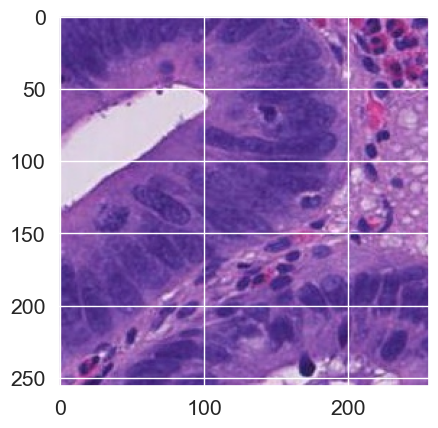

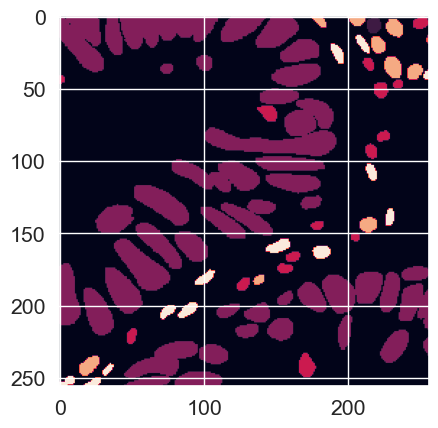

4000


In [100]:
dataset = MyDataset()

In [101]:
print(dataset[0][0].shape)
print(dataset[0][1].shape)
print(dataset[0][2])
print("max_w", dataset.max_w)
print("max_h", dataset.max_h)

torch.Size([3, 64, 64])
torch.Size([64, 64])
tensor(2, dtype=torch.uint8)
max_w 91
max_h 66


In [102]:
print(len(dataset))

630652


In [103]:
hist = [0, 0, 0, 0, 0, 0, 0]
for img, lab, cl in dataset:
    hist[cl.item()] += 1

print(hist)

[0, 38200, 279593, 120333, 32586, 31104, 128836]


In [104]:
train_data, test_data = random_split(dataset, [500000, 130652])
dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)

In [39]:
# classes = ['neutrophil', 'epithelial', 'lymphocyte', 'plasma', 'eosinophil', 'connective']
# classes
dataiter = iter(dataloader)
data = dataiter.next()
images, labels, classes = data
plt.imshow(images[0].permute(1, 2, 0))
plt.title("image")
plt.show()
images[0]
# pred = net(images.float())
# pred[0]
# print(features.shape, labels.shape, pred.shape, pred.squeeze(1).shape)
# print(features.type(), labels.type(), pred.type(), pred.squeeze(1).type())
# loss_fn(pred.squeeze(1), classes)

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [105]:
num_epochs = 20
total_samples = len(train_data)
n_iterations = math.ceil(total_samples/32)
print(total_samples, n_iterations)
net = Net()
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()
# loss_fn = nn.KLDivLoss()
# opt = torch.optim.Adam(net.parameters(), lr=0.001)
opt = torch.optim.SGD(net.parameters(), lr=0.0001)

500000 15625


In [114]:
start_time = datetime.now()
for epoch in range(num_epochs):
    running_loss = 0
    for i, (inputs, labels, classes) in enumerate(dataloader):
        opt.zero_grad()
        outputs = net(inputs.float())
        loss = loss_fn(outputs, classes)
        loss.backward()
        opt.step()
        wandb.log({"loss_3": loss})
        # forward, backwards, update
        running_loss += loss.item()
        if (i+1) % 1000 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, loss {running_loss / 1000}, time {(datetime.now()-start_time)}')
            running_loss = 0

epoch 1/20, step 1000/15625, loss 2.0185360728502273, time 0:00:35.365171
epoch 1/20, step 2000/15625, loss 2.020192172527313, time 0:01:20.096086
epoch 1/20, step 3000/15625, loss 2.0145591510534286, time 0:02:05.683171
epoch 1/20, step 4000/15625, loss 2.0213360158205034, time 0:02:44.818261
epoch 1/20, step 5000/15625, loss 2.019698398590088, time 0:03:22.508493
epoch 1/20, step 6000/15625, loss 2.013476994752884, time 0:04:02.546602
epoch 1/20, step 7000/15625, loss 2.023217409491539, time 0:04:40.149838
epoch 1/20, step 8000/15625, loss 2.0178123478889467, time 0:05:19.650725
epoch 1/20, step 9000/15625, loss 2.017452282309532, time 0:05:59.613960
epoch 1/20, step 10000/15625, loss 2.019059041619301, time 0:06:37.545364
epoch 1/20, step 11000/15625, loss 2.0228917535543443, time 0:07:17.162887
epoch 1/20, step 12000/15625, loss 2.0261052541732787, time 0:07:58.136967
epoch 1/20, step 13000/15625, loss 2.024066188454628, time 0:08:37.591493
epoch 1/20, step 14000/15625, loss 2.0278

KeyboardInterrupt: 

In [ ]:
torch.save(net, "net_g_cell_crop_3")

In [82]:
net = Net()
net = torch.load("net_g_cell_crop_1")

In [115]:
dataloader_test = DataLoader(dataset=test_data, batch_size=32, shuffle=True)
dataiter = iter(dataloader)

tensor([ 0.0948,  0.0701,  0.3324, -1.1829, -0.0659, -0.1551, -0.4977])
pred 2
truth 3


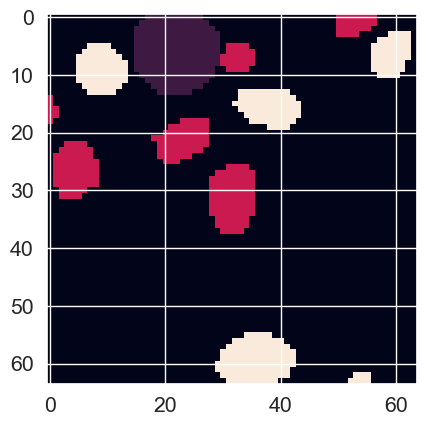

In [116]:
data = next(dataiter)
images, labels, classes = data
with torch.no_grad():
    outputs = net(images.float())
    print(outputs[0])
    print(f'pred {np.where(outputs[0] == outputs[0].max())[0][0]}')
    print(f'truth {classes[0].item()}')
    # print(f'truth {np.where(classes[0] == classes[0].max())[0][0]}')
    plt.imshow(labels[0].detach().numpy())
    plt.show()

In [117]:
total_samples = len(test_data)
n_iterations = math.ceil(total_samples/32)
correct = 0
total = 0
confusion_matrix = np.zeros((6, 6), dtype=np.uint8)
total_predictions = np.zeros(6, dtype=np.uint8)
total_classes = np.zeros(6, dtype=np.uint8)
with torch.no_grad():
    for i, (inputs, labels, classes) in enumerate(dataloader_test):
        outputs = net(inputs.float())
        _, predicted = torch.max(outputs.data, 1)
        total += classes.size(0)
        correct += (predicted == classes).sum().item()
        # [confusion_matrix[pr-1, cl-1] += 1 for i in zip(predicted, classes)]
        for pr, cl in zip(predicted, classes):
            confusion_matrix[pr.item()-1, cl.item()-1] += 1
            total_predictions[pr.item()-1] += 1
            total_classes[cl.item()-1] += 1
        if (i+1) % 500 == 0:
            print(f'step {i+1} / {n_iterations}')

print(f'Accuracy of the network on {total} test images: {(correct / total) * 100:.2f} %')

step 500 / 4083
step 1000 / 4083
step 1500 / 4083
step 2000 / 4083
step 2500 / 4083
step 3000 / 4083
step 3500 / 4083
step 4000 / 4083
Accuracy of the network on 130652 test images: 41.54 %


In [118]:
print("predictions count: ", total_predictions)
print("classes count:     ", total_classes)

predictions count:  [253  64   0   6  18   7]
classes count:      [208  63 110 121 243 115]


In [119]:
confusion_matrix
#   g r o u n d  t h r u t h
# p
# r
# e
# d
# i
# c
# t

array([[206, 214, 100, 186, 125, 190],
       [ 36,  55, 216,   9,   0,   4],
       [  0,   0,   0,   0,   0,   0],
       [  0,   6,   0,   0,   0,   0],
       [  0,  18,   0,   0,   0,   0],
       [222,  26,  50, 182, 118, 177]], dtype=uint8)

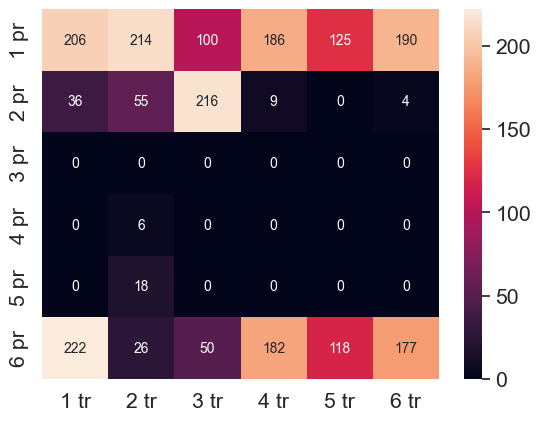

In [120]:
df = pd.DataFrame(confusion_matrix, [str(i) + " pr" for i in range(1,7)], [str(i) + " tr" for i in range(1,7)])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 10}, fmt='g') # font size

plt.show()

# RESULTS

## 2 layers, without augmentation, net_cell_crop_1

Accuracy of the network on 53921 test images: 68.08 %

classes: [18457, 3539, 150346, 56178, 16374, 2905, 106122]

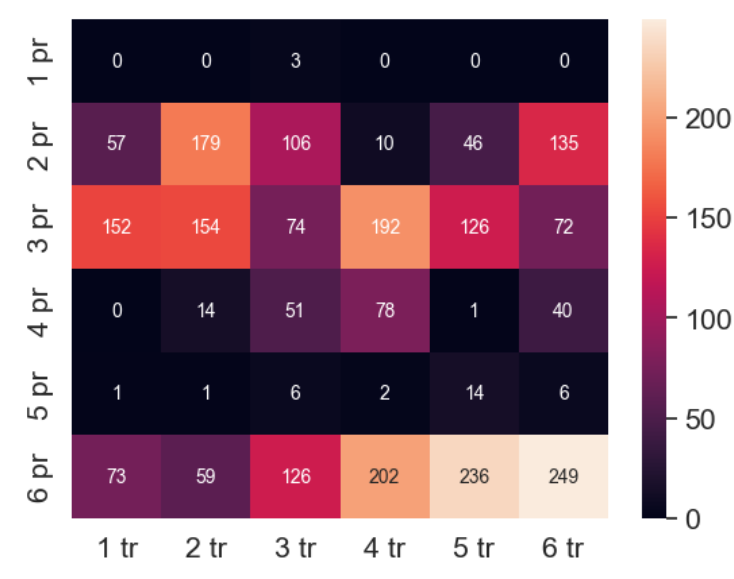

---

## 2 layers, with (7) augmentation on classes 1 and 5, net_cell_crop_2

Accuracy of the network on 59029 test images: 66.39 %

classes: [18457, 28312, 150346, 56178, 16374, 23240, 106122]

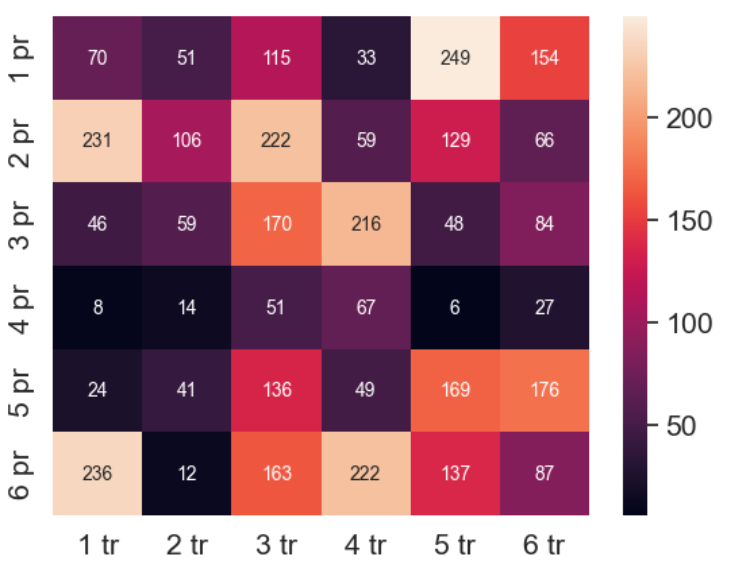

---

## 2 layers, with (7) augmentation on classes 1 and 5, better anotated dataset, net_g_cell_crop_1

Accuracy of the network on 130652 test images: 75.97 %

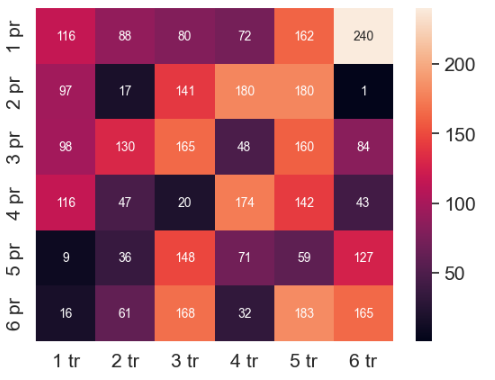

---

## 3 layers, with (7) augmentation on classes 1 and 5, better anotated dataset, net_g_cell_crop_2

Accuracy of the network on 130652 test images: 70.80 %

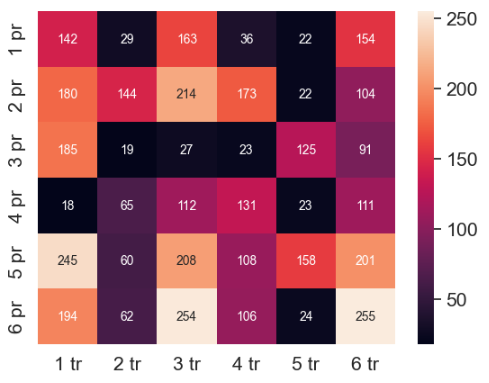

---

## 2 layers, with aug, size 64 -> BAD

Accuracy of the network on 130652 test images: 41.54 %

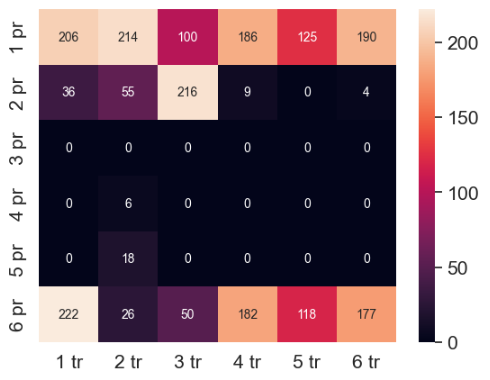